## Actor-Weight Behavior in OpAL

Reproducing OpAL G/NG weight behavior and results of OpAL* modifications in: <br>
-  Fig11 of Moller and Bogacz, 2019
-  Learning curves for 2000 trials
-  Random walk reward
-  Simple Switch point 

In [18]:
# Using Colab? Uncomment below
# from google.colab import drive
# drive.mount('/content/drive/') # mount your google drive to access file

## change to the notebook directory
# %cd '/content/drive/MyDrive/Colab Notebooks/opal-star/'

In [19]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import stability
import dynamics
import plot_dynamics
import learning

## Moller and Bogacz, 2019

In [20]:
nTrials = 40
alpha_a = 0.3
alpha_c = 0.3
V0 = 0
beta = 1
pgrad= False
state  = stability.simulate_Bogacz2019(nTrials,alpha_a,alpha_c,V0,beta,mag=3,norm=False,pgrad=pgrad)
stateNA = stability.simulate_Bogacz2019(nTrials,alpha_a,alpha_c,V0,beta,mag=3,anneal=True, use_var=False, norm= True, pgrad=pgrad, T=50.)   # normalization and annealing

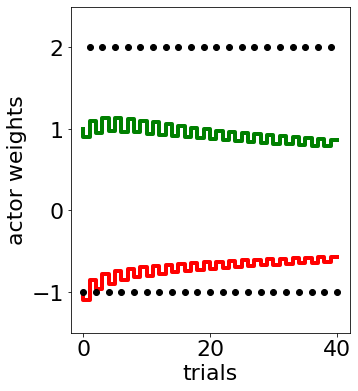

In [21]:
# plot actor weights
to_plot = state           # run for original fig
to_plot = stateNA         # run for normalization + annealing
plt.rcParams.update({'font.size': 22})
xaxis = np.arange(0,nTrials+1)
fig, ax = plt.subplots(figsize=(5, 6))
ax.step(xaxis,to_plot.QG[:,0],color = "green",linewidth=4.0)
ax.step(xaxis,-1*to_plot.QN[:,0],color = "red",linewidth=4.0)
plt.ylabel("actor weights")
plt.xlabel("trials")
plt.ylim([-1.5,2.5])
ax.plot(xaxis,np.mod(xaxis,2)*3-1,'o', color='black')

Text(0.5, 0, 'trials')

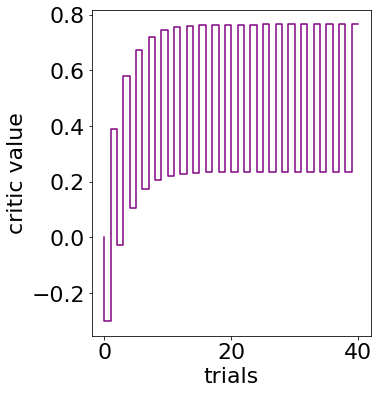

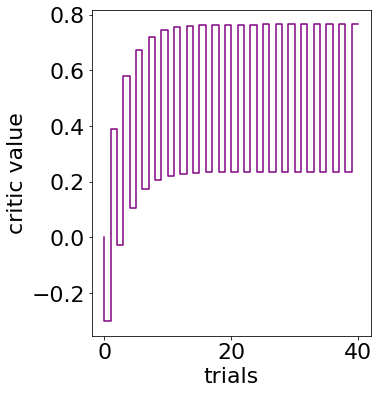

In [22]:
# plot critic values over time
xaxis = np.arange(0,nTrials+1)
fig, ax = plt.subplots(figsize=(5, 6))
ax.step(xaxis,state.V[:,0], color = "purple")
plt.ylabel("critic value")
plt.xlabel("trials")
#plt.ylim([-1.5,2])

fig, ax = plt.subplots(figsize=(5, 6))
ax.step(xaxis,stateNA.V[:,0], color = "purple")
plt.ylabel("critic value")
plt.xlabel("trials")

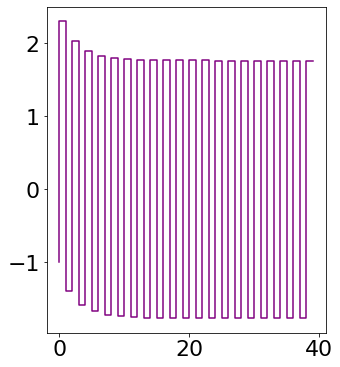

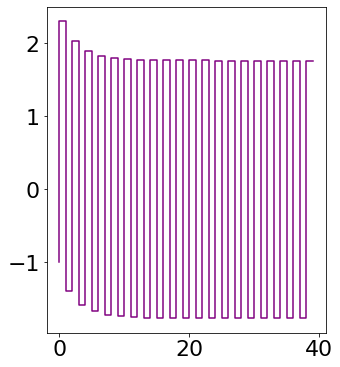

In [23]:
# plot prediction errors over time
xaxis = np.arange(0,nTrials)
fig, ax = plt.subplots(figsize=(5, 6))
ax.step(xaxis,state.PE, color = "purple")
#plt.ylim([-1.5,2])

xaxis = np.arange(0,nTrials)
fig, ax = plt.subplots(figsize=(5, 6))
ax.step(xaxis,stateNA.PE, color = "purple")

# Appendix 1

Single simulation learning dynamics for 2000 trials

NOTE 1: The Appendix initializes G/N to .1 which will accelerate decay. Here, we initialize to 1, as is standard in other OpAL implementations

NOTE 2: Should also run the FULL range of probabilities (not just rich and lean) as sometimes there is irregular behavior at rich/lean boundary

In [24]:
# setup
n_trials = 1000
n_states = 100
r_mag = 1
l_mag = 0
probs = np.array([0.9,0.8,0.7,0.3,0.2,0.1])     # probabilities to try
probs = np.arange(0.1,1,.1)                     # full prob range


### OpAL

In [25]:
# initialize parameters
v0 = 0.5
C = 0

alpha_c = 0.05
alpha_a = 0.2
beta = 5 # needed for Act figure
params = (alpha_c, alpha_a, beta)

hebb = True
crit = "SA"
norm = False
anneal = False
pgrad = False
T = 10

decay_to_prior = False      # Franklin/Frank, actor decay
decay_to_prior_gamma = 6

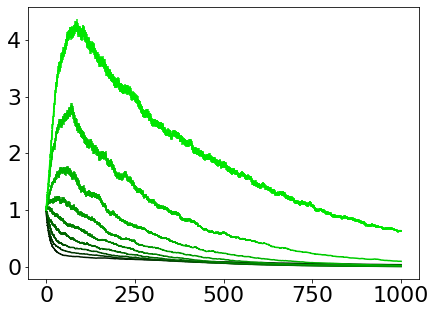

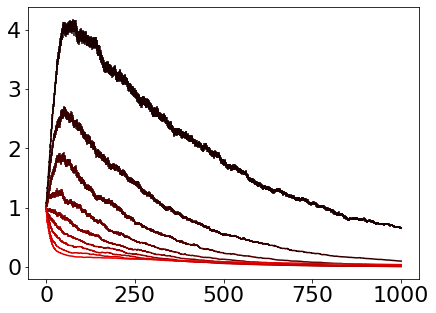

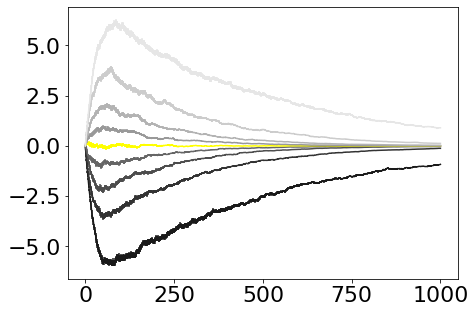

In [26]:
fig1, ax1 = plt.subplots(figsize=(7, 5))   # go actor evolution
# plt.ylim([0,2.0])
fig2, ax2 = plt.subplots(figsize=(7, 5))   # no go actor evolution
# plt.ylim([0,2.0])
fig3, ax3 = plt.subplots(figsize=(7, 5))   # act val evolution
axs = [ax1,ax2,ax3]

all_states = []
for p in probs:
    env = "%d_10_1" %(p*100)
    states = dynamics.simulate_learning(params,n_states,n_trials,env=env,v0=v0,r_mag=r_mag,l_mag=l_mag,norm=norm,anneal=anneal,pgrad=pgrad,crit=crit,hebb=hebb,decay_to_prior=decay_to_prior,decay_to_prior_gamma=decay_to_prior_gamma)
    plot_dynamics.avg_qs_dynamics(states,n_trials,n_states,C,axs,p,beta=1.5,rho=0.0)
    all_states.append(states)

### + Annealing + Normalization

In [27]:
# initialize parameters
v0 = 0.5
C = 0

alpha_c = .1 
alpha_a = .7   
beta = 3.5 # needed for Act figure #3.5
params = (alpha_c, alpha_a, beta)

hebb = True
crit = "SA"

# norm magnitude
norm = True # should not actually affect results, normalizing by 1
pgrad = False
mag = r_mag - l_mag

# annealing
anneal = True
use_var = True
T = 10

decay_to_prior = False     # Franklin/Frank, actor decay
decay_to_prior_gamma = 10

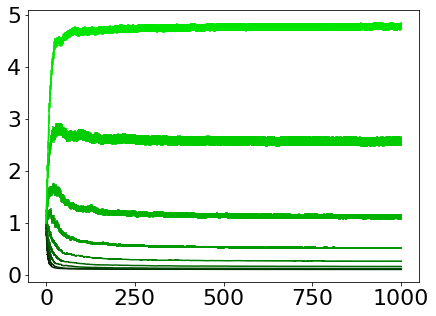

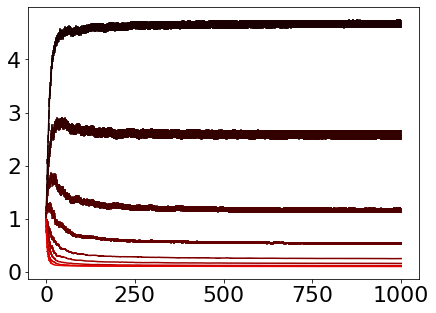

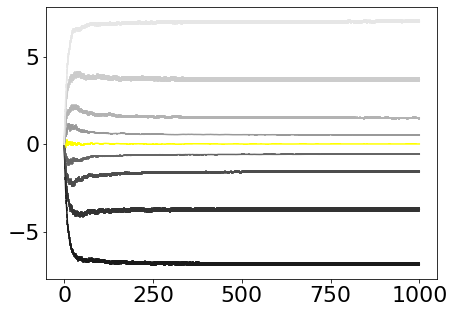

In [28]:
fig1, ax1 = plt.subplots(figsize=(7, 5))   # go actor evolution
# plt.ylim([0,1.75])
fig2, ax2 = plt.subplots(figsize=(7, 5))   # no go actor evolution
# plt.ylim([0,1.75])
fig3, ax3 = plt.subplots(figsize=(7, 5))   # act val evolution
axs = [ax1,ax2,ax3]

all_states = []
for p in probs:
    env = "%d_10_1" %(p*100)
    states = dynamics.simulate_learning(params,n_states,n_trials,env=env,hebb=hebb,crit=crit,v0=v0,r_mag=r_mag,l_mag=l_mag,norm=norm,mag=mag, decay_to_prior=decay_to_prior,decay_to_prior_gamma=decay_to_prior_gamma, pgrad=pgrad,anneal=anneal,use_var=use_var,T=T)
    plot_dynamics.avg_qs_dynamics(states,n_trials,n_states,C,axs,p,beta=1.5,rho=0.0)
    all_states.append(states)

### + Bayesian Critic (OpAL*)

Dynamics here seem more unstable introducing the Bayesian critic, all else held fixed <br>
Playing with annealing or learning rates may help stabilize?

In [29]:
# initialize parameters
v0 = np.array([0.,0.]) # Bayesian critic, no prior

alpha_c = 0.2
alpha_a = 0.2
beta = 5 # needed for Act figure
params = (alpha_c, alpha_a, beta)

hebb = True
crit = "Bayes-SA"

# norm magnitude
norm = True
mag = r_mag - l_mag  

# annealing
anneal = True
pgrad = False
T = 50

# DA mod - should not affect sims, only 1 option
mod = "constant"    
phi = 1.0
k = 1

decay_to_prior = False # Franklin/Frank, actor decay
decay_to_prior_gamma = 5

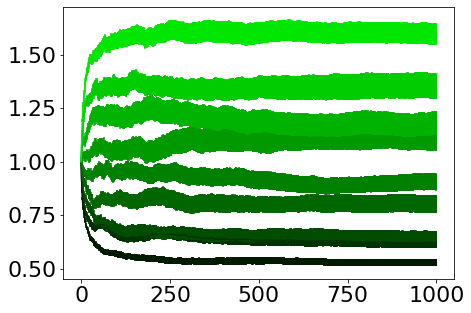

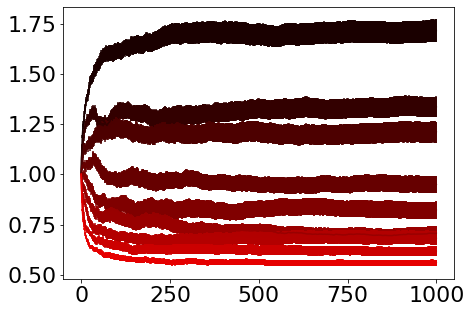

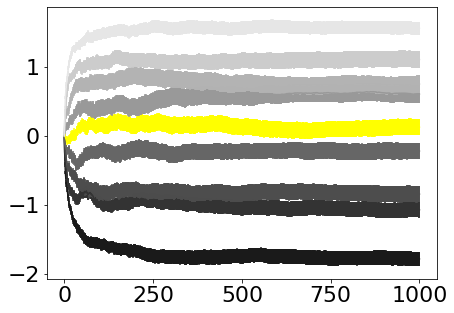

In [30]:
fig1, ax1 = plt.subplots(figsize=(7, 5))   # go actor evolution
fig2, ax2 = plt.subplots(figsize=(7, 5))   # no go actor evolution
fig3, ax3 = plt.subplots(figsize=(7, 5))   # act val evolution
axs = [ax1,ax2,ax3]

all_states = []
C = 0
for p in probs:
    env = "%d_10_1" %(p*100)
    states = dynamics.simulate_learning(params,n_states,n_trials,env=env,hebb=hebb,crit=crit,v0=v0,r_mag=r_mag,l_mag=l_mag,norm=norm,mag=mag,anneal=anneal, decay_to_prior=decay_to_prior, decay_to_prior_gamma=decay_to_prior_gamma, pgrad=pgrad,T=T,mod=mod,phi=phi,k=k)
    plot_dynamics.avg_qs_dynamics(states,n_trials,n_states,C,axs,p,beta=1.5,rho=0.0)
    all_states.append(states)

# Appendix 2

Random walk of reward

In [31]:
# paradigm setup
n_trials = 1000
r_mag = 1
l_mag = 0

### OpAL

In [32]:
# initialize parameters
v0 = 0.5
C = 0

alpha_c = 0.2
alpha_a = 0.2
beta = 5 # needed for Act figure
params = (alpha_c, alpha_a, beta)

hebb = True
crit = "SA"

# norm magnitude
norm = False
mag = r_mag - l_mag

# annealing
anneal = False
use_var = False
pgrad = False
T = 100
decay_to_prior = False      # Franklin/Frank, actor decay
decay_to_prior_gamma = 6

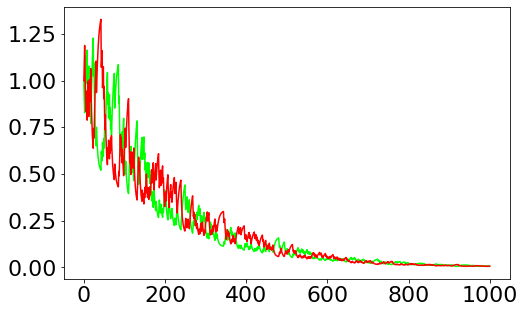

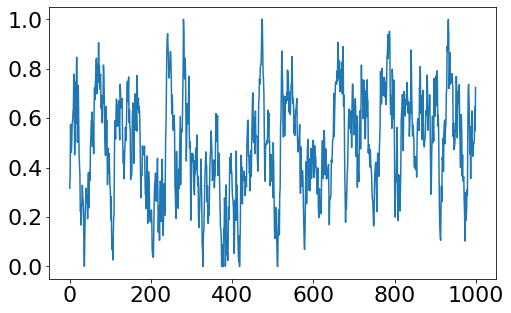

In [33]:
np.random.seed(0)

state  = stability.simulate_appendix2(n_trials,alpha_a,alpha_c,v0,beta,mag=mag,norm=norm,anneal=anneal,pgrad=pgrad,decay_to_prior=decay_to_prior,decay_to_prior_gamma = decay_to_prior_gamma,T=T)

fig1, ax1 = plt.subplots(figsize=(8, 5))   # go actor evolution and  no go actor evolution 
fig2, ax2 = plt.subplots(figsize=(8, 5))   # go actor evolution and  no go actor evolution 
axs = [ax1,ax1]
plot_dynamics.avg_qs([state],n_trials,1,C,axs,1.0)
ax2.plot(np.arange(0,n_trials),state.probs)

### + Annealing + Normalization

In [34]:
# initialize parameters
v0 = 0.5
C = 0
n_trials = 1000

alpha_c = 0.2
alpha_a = 0.2
beta = 5 # needed for Act figure
params = (alpha_c, alpha_a, beta)

hebb = True
crit = "SA"

# norm magnitude
norm = True
mag = r_mag - l_mag

# annealing
anneal = True
use_var = True
pgrad = False
T = 50

decay_to_prior = False      # Franklin/Frank, actor decay
decay_to_prior_gamma = 3

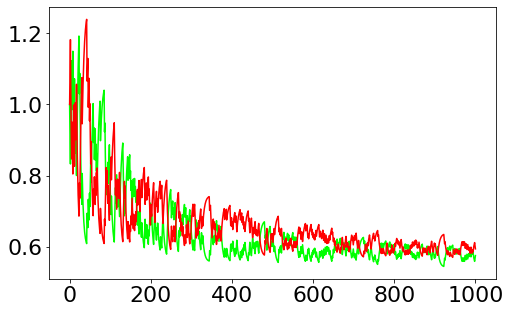

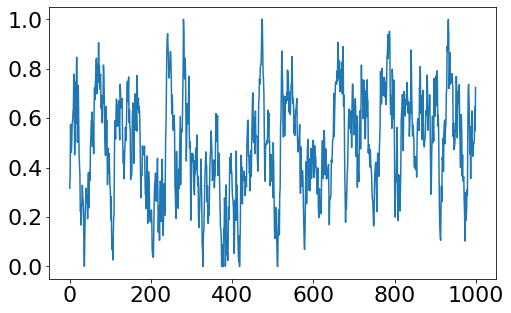

In [35]:
np.random.seed(0)
state  = stability.simulate_appendix2(n_trials,alpha_a,alpha_c,v0,beta,mag=mag,norm=norm,anneal=anneal,use_var=use_var,pgrad=pgrad,decay_to_prior=decay_to_prior,decay_to_prior_gamma = decay_to_prior_gamma,T=T)

fig1, ax1 = plt.subplots(figsize=(8, 5))   # go actor evolution and  no go actor evolution 
fig2, ax2 = plt.subplots(figsize=(8, 5))   # go actor evolution and  no go actor evolution 
axs = [ax1,ax1]
plot_dynamics.avg_qs([state],n_trials,1,C,axs,1.0)
ax2.plot(np.arange(0,n_trials),state.probs)

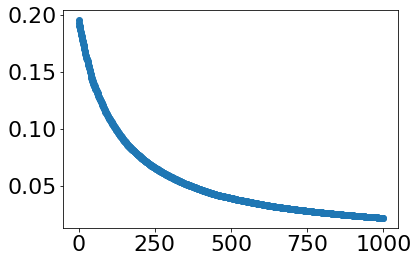

In [36]:
plt.scatter(np.arange(n_trials), state.alphags)

### + Bayesian critic

In [37]:
# initialize parameters
v0 = 0.5
C = 0

alpha_c = 0.2
alpha_a = 0.2
beta = 5 # needed for Act figure
params = (alpha_c, alpha_a, beta)

hebb = True
crit = "Bayes-SA"

# norm magnitude
norm = True
mag = r_mag - l_mag

# annealing
anneal = True
use_var = True
pgrad = False
T = 50
decay_to_prior = True      # Franklin/Frank, actor decay
decay_to_prior_gamma = 3

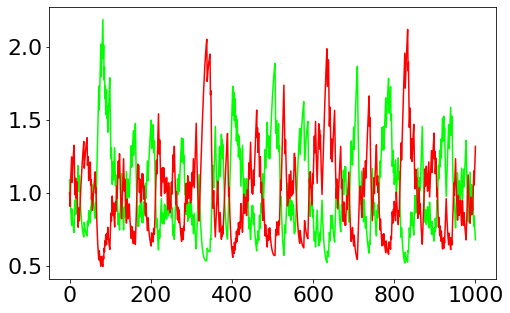

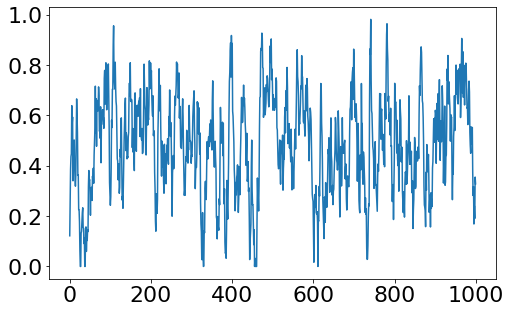

In [38]:
state  = stability.simulate_appendix2(n_trials,alpha_a,alpha_c,v0,beta,mag=mag,norm=norm,anneal=anneal,use_var=use_var,pgrad=pgrad,decay_to_prior=decay_to_prior,decay_to_prior_gamma = decay_to_prior_gamma, T=T, version="OpAL*")

fig1, ax1 = plt.subplots(figsize=(8, 5))   # go actor evolution and  no go actor evolution 
fig2, ax2 = plt.subplots(figsize=(8, 5))   # go actor evolution and  no go actor evolution 
axs = [ax1,ax1]
plot_dynamics.avg_qs([state],n_trials,1,C,axs,1.0)
ax2.plot(np.arange(0,n_trials),state.probs)

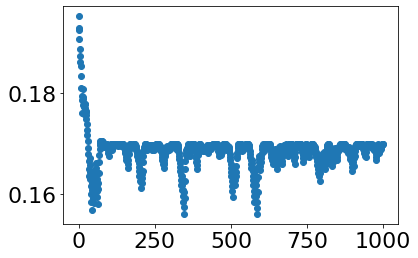

In [39]:
plt.scatter(np.arange(n_trials), state.alphags)

# Simple switch points

### Uncertainty in what to choose
Simulation begins with a 85%:10% reward contigency for option A and B, respectively. The optimal action switches after 50 trials of learning.

NOTE: I have code for resetting the annealing rate at the switch point

In [40]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import stability
import dynamics
import plot_dynamics
import learning

In [41]:
# set up
env_start = np.array([.8,.5])   # env at start of experiment
env_switch = np.array([.5,.8])  # environment after switchpoint

n_states = 100   # how many simulations to avg over
n_trials = 300  # how many trials of training
switch = n_trials/2     # trial number to switch env

r_mag = 1
l_mag = 0

In [42]:
# model details 

alpha_c = 0.06 # not actually used for Bayesian critic
alpha_a = 0.2
beta =  2 # 2.43
params = (alpha_c,alpha_a, beta)

# Use a standard RL critic (uncomment below)
crit = "SA"         
v0 = 0.5            # initial Q value for critic
# -------------------------
# Use a bayesian critic (uncomment below)
# crit = "Bayes-SA"     
# v0 = np.array([0.,0.])  # initialize prior
# -------------------------

decay_to_prior = False   # True - Franklin/Frank, actor decay - Trgger to see effects of decay
decay_to_prior_gamma = 5
hebb = True   

norm = True
mag = r_mag - l_mag

anneal = True    # should I anneal my learning rate? 
use_var = True   # use variance to adjust annealing - Trgger to see effects of Bayesian Annealing vs. Fixed
pgrad =  False
T = 50          # if annealing, how quickly? - NOTE: I also have code script to reset learning rate to initial value after switch point

# DA mod 
mod = "beta"        # Don't modulate dopamine at all
rho = 0.0               # equally weight G/N actors - applied when mod = "constant"

phi = 1.0               # applied when mod = "Beta"
k = 20

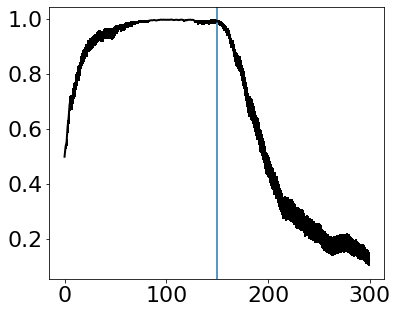

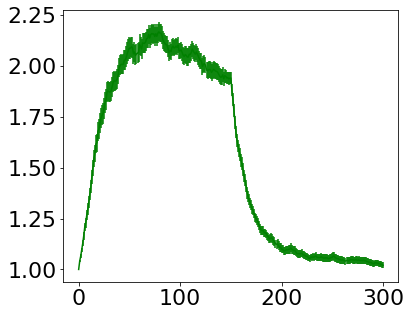

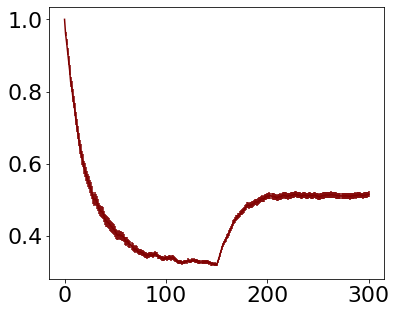

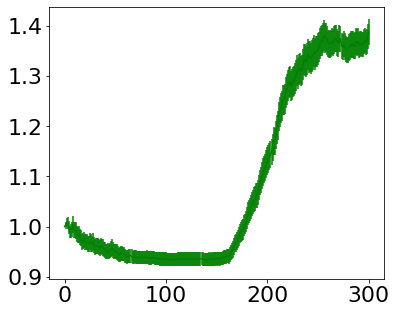

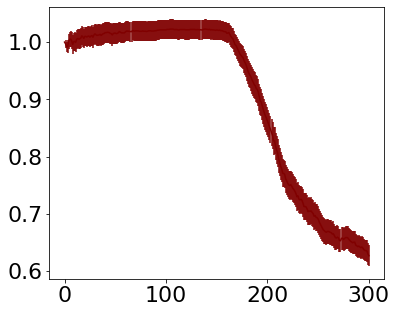

In [43]:
# run 
states = learning.simulate(params,n_states,n_trials,env=env_start,hebb=hebb,crit=crit,v0=v0,r_mag=r_mag,l_mag=l_mag,norm=norm,mag=mag,anneal=anneal,use_var=use_var,pgrad=pgrad,T=T,mod=mod,phi=phi,k=k,decay_to_prior=decay_to_prior,decay_to_prior_gamma=decay_to_prior_gamma,env_switch=env_switch,switch=switch)

# plot
fig1, axs1 = plt.subplots(figsize=(6, 5))
# choice 0
fig2, axs2 = plt.subplots(figsize=(6, 5))
fig3, axs3 = plt.subplots(figsize=(6, 5))
# choice 0
fig4, axs4 = plt.subplots(figsize=(6, 5))
fig5, axs5 = plt.subplots(figsize=(6, 5))

axs=[axs2, axs3]
axs45=[axs4, axs5]

C=0 # which option to plot, 0 or 1
plot_dynamics.avg_sm(states,n_trials,n_states,0,axs1,"black")
plot_dynamics.avg_qs(states,n_trials,n_states,C,axs,.5)
plot_dynamics.avg_qs(states,n_trials,n_states,1,axs45,.5)
axs1.axvline(switch)

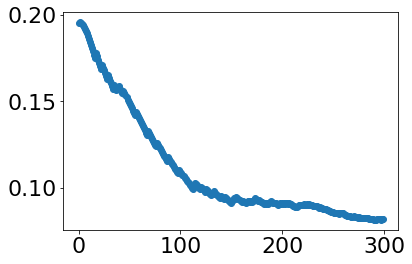

In [44]:
plt.scatter(np.arange(n_trials), states[0].alphags)

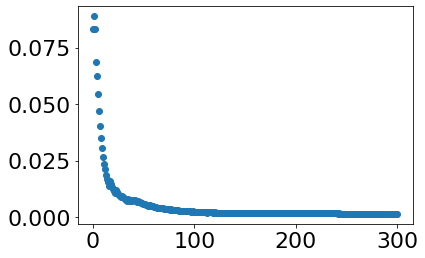

In [45]:
plt.scatter(np.arange(n_trials+1), states[0].var)

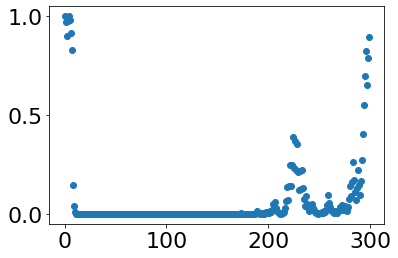

In [46]:
plt.scatter(np.arange(n_trials), states[0].H)

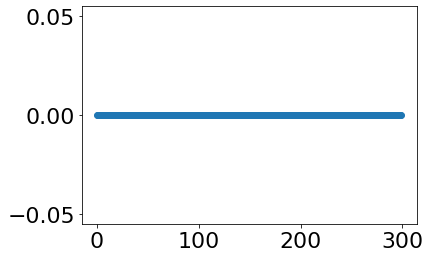

In [47]:
plt.scatter(np.arange(n_trials), states[0].gammas[1:])

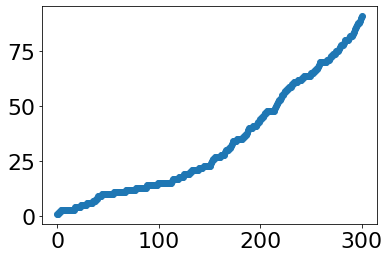

In [48]:
plt.scatter(np.arange(n_trials+1), states[0].beta_dist[:,1])

In [49]:
states[0].beta_dist[550,:]

IndexError: index 550 is out of bounds for axis 0 with size 301

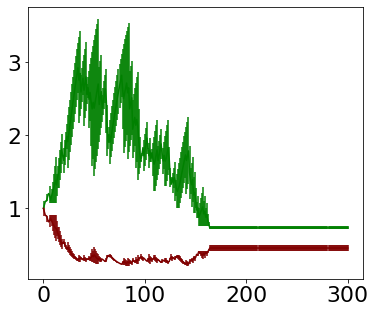

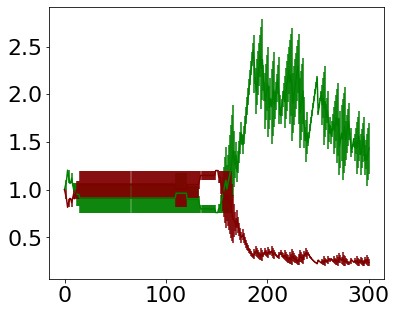

In [ ]:
# G and N for each action
fig1, axs1 = plt.subplots(figsize=(6, 5))
fig2, axs2 = plt.subplots(figsize=(6, 5)) 
axs=[axs1, axs1]
plot_dynamics.avg_qs(states,n_trials,n_states,0,axs,.5)
axs=[axs2, axs2]
plot_dynamics.avg_qs(states,n_trials,n_states,1,axs,.5) 

In [ ]:

# Switch from Rich to Lean

env_start = np.array([.9,.70])   # env at start of experiment
env_switch = np.array([.1,.30])  # environment after switchpoint

n_states = 100   # how many simulations to avg over
n_trials = 100  # how many trials of training
switch = 50     # trial number to switch env

r_mag = 1
l_mag = 0

In [ ]:
# model details
decay_to_prior = False

alpha_c = 0.06 # not actually used for Bayesian critic
alpha_a = 0.5
beta =  1.
params = (alpha_c,alpha_a, beta)

# crit = "SA"         # Use a standard RL critic
# v0 = 0.5            # initial Q value for critic
crit = "Bayes-SA"       # Use a standard RL critic
v0 = np.array([0.,0.])  # initial Q value for critic

decay_to_prior = True       # Franklin/Frank, actor decay
decay_to_prior_gamma = 5

hebb = True      

norm = True
mag = r_mag - l_mag

anneal = True     # should I anneal my learning rate? 
pgrad = False
T = 50              # if annealing, how quickly? - NOTE: I also have code script to reset learning rate to initial value after switch point

# DA mod 
mod = "beta"       # Don't modulate dopamine at all
rho = 0.0               # equally weight G/N actors - applied when mod = "constant"

phi = 1.0               # applied when mod = "Beta"
k = 1

../opal.py:312: RuntimeWarning: divide by zero encountered in double_scalars
  alphag = alphag/(1. + 0.1/(self.var[idx]*T))  # for T = 50, trial 1 0.1/T*var =  .024, similar to 1/50
../opal.py:313: RuntimeWarning: divide by zero encountered in double_scalars
  alphan = alphan/(1. + 0.1/(self.var[idx]*T))


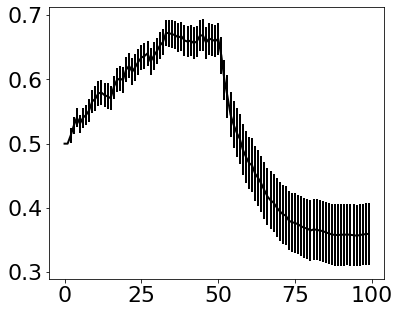

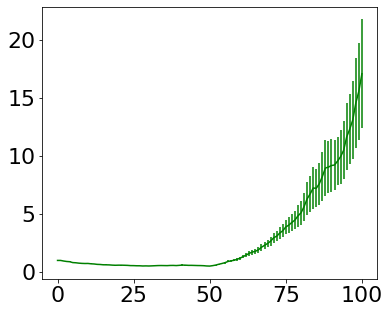

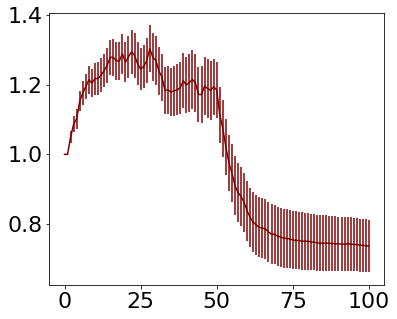

In [ ]:
# run 
states = learning.simulate(params,n_states,n_trials,env=env_start,hebb=hebb,crit=crit,v0=v0,r_mag=r_mag,l_mag=l_mag,norm=norm,mag=mag,anneal=anneal,pgrad=pgrad,T=T,mod=mod,phi=phi,k=k,decay_to_prior=decay_to_prior,decay_to_prior_gamma=decay_to_prior_gamma,env_switch=env_switch,switch=switch)

# plot
fig1, axs1 = plt.subplots(figsize=(6, 5))
fig2, axs2 = plt.subplots(figsize=(6, 5))
fig3, axs3 = plt.subplots(figsize=(6, 5))
axs=[axs2, axs3]

C=0 # which option to plot, 0 or 1
plot_dynamics.avg_sm(states,n_trials,n_states,0,axs1,"black")
plot_dynamics.avg_qs(states,n_trials,n_states,C,axs,.5)

In [ ]:
# Switch from Lean to Rich

env_start = np.array([.3,.1])   # env at start of experiment
env_switch = np.array([.7,.9])  # environment after switchpoint

n_states = 100   # how many simulations to avg over
n_trials = 100  # how many trials of training
switch = 50     # trial number to switch env

r_mag = 1
l_mag = 0

In [ ]:
# model details 

alpha_c = 0.06 # not actually used for Bayesian critic
alpha_a = 0.5
beta =  1.
params = (alpha_c,alpha_a, beta)

# crit = "SA"         # Use a standard RL critic
# v0 = 0.5            # initial Q value for critic
crit = "Bayes-SA"       # Use a standard RL critic
v0 = np.array([0.,0.])  # initial Q value for critic

decay_to_prior = True       # Franklin/Frank, actor decay
decay_to_prior_gamma = 5

hebb = True      

norm = True
mag = r_mag - l_mag

anneal = True     # should I anneal my learning rate? 
pgrad = False
T = 50              # if annealing, how quickly? - NOTE: I also have code script to reset learning rate to initial value after switch point

# DA mod 
mod = "beta"       # Don't modulate dopamine at all
rho = 0.0               # equally weight G/N actors - applied when mod = "constant"

phi = 1.0               # applied when mod = "Beta"
k = 1

../opal.py:312: RuntimeWarning: divide by zero encountered in double_scalars
  alphag = alphag/(1. + 0.1/(self.var[idx]*T))  # for T = 50, trial 1 0.1/T*var =  .024, similar to 1/50
../opal.py:313: RuntimeWarning: divide by zero encountered in double_scalars
  alphan = alphan/(1. + 0.1/(self.var[idx]*T))


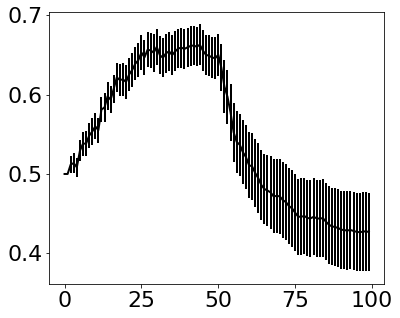

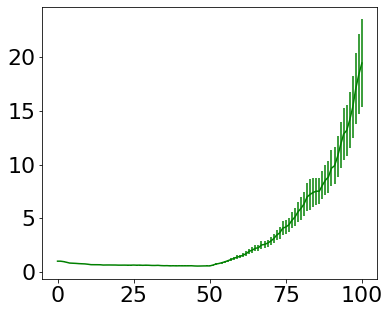

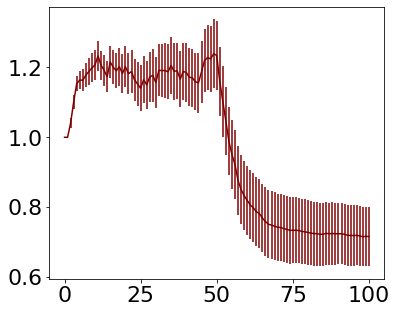

In [ ]:
# run 
states = learning.simulate(params,n_states,n_trials,env=env_start,hebb=hebb,crit=crit,v0=v0,r_mag=r_mag,l_mag=l_mag,norm=norm,mag=mag,anneal=anneal,pgrad=pgrad,T=T,mod=mod,phi=phi,k=k,decay_to_prior=decay_to_prior,decay_to_prior_gamma=decay_to_prior_gamma,env_switch=env_switch,switch=switch)

# plot
fig1, axs1 = plt.subplots(figsize=(6, 5))
fig2, axs2 = plt.subplots(figsize=(6, 5))
fig3, axs3 = plt.subplots(figsize=(6, 5))
axs=[axs2, axs3]

C=0 # which option to plot, 0 or 1
plot_dynamics.avg_sm(states,n_trials,n_states,0,axs1,"black")
plot_dynamics.avg_qs(states,n_trials,n_states,C,axs,.5)

# Rankings of G/N values for multiple actions

In [ ]:
 
env_start = np.array([.3,.2,.1])   # env at start of experiment 
env_switch = np.array([.3,.2,.1])   # env at start of experiment 

n_states = 100   # how many simulations to avg over
n_trials = 200  # how many trials of training
 

r_mag = 1
l_mag = 0

In [ ]:
alpha_c = 0.06 # not actually used for Bayesian critic
alpha_a = 0.84
beta =  2.43
params = (alpha_c,alpha_a, beta)

# crit = "SA"         # Use a standard RL critic
# v0 = 0.5            # initial Q value for critic
crit = "Bayes-SA"       # Use a standard RL critic
#crit = "SA"
v0 = np.array([0.,0.])  # initial Q value for critic

decay_to_prior = True   # Franklin/Frank, actor decay
decay_to_prior_gamma = 8
hebb = True   

norm = True
mag = r_mag - l_mag

anneal = True  # should I anneal my learning rate? 
pgrad =  False
T = 10               # if annealing, how quickly? - NOTE: I also have code script to reset learning rate to initial value after switch point

# DA mod 
mod = "beta"        # Don't modulate dopamine at all
rho = 0.0               # equally weight G/N actors - applied when mod = "constant"

phi = 1.0               # applied when mod = "Beta"
k = 20

../opal.py:314: RuntimeWarning: divide by zero encountered in double_scalars
  alphag = alphag/(1. + 0.1/(self.var[idx]*T))  # for T = 50, trial 1 0.1/T*var =  .024, similar to 1/50
../opal.py:315: RuntimeWarning: divide by zero encountered in double_scalars
  alphan = alphan/(1. + 0.1/(self.var[idx]*T))


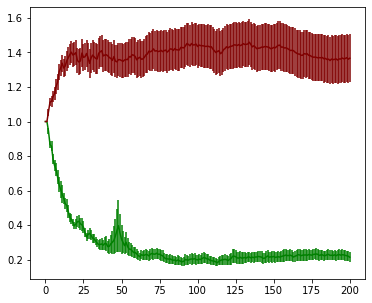

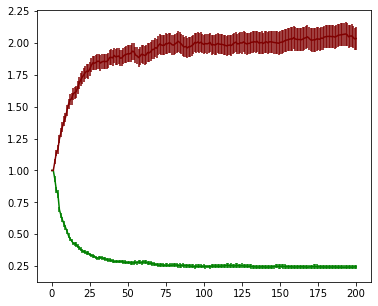

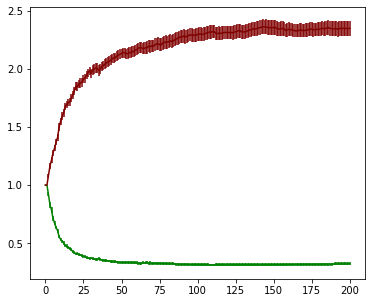

In [ ]:
states = learning.simulate(params,n_states,n_trials,env=env_start,hebb=hebb,crit=crit,v0=v0,r_mag=r_mag,l_mag=l_mag,norm=norm,mag=mag,anneal=anneal,pgrad=pgrad,T=T,mod=mod,phi=phi,k=k,decay_to_prior=decay_to_prior,decay_to_prior_gamma=decay_to_prior_gamma,env_switch=env_switch,switch=switch)

# plot
 
fig1, axs1 = plt.subplots(figsize=(6, 5))
fig2, axs2 = plt.subplots(figsize=(6, 5))
fig3, axs3 = plt.subplots(figsize=(6, 5))

axs=[axs1, axs1]
plot_dynamics.avg_qs(states,n_trials,n_states,0,axs,.5)
axs=[axs2, axs2]
plot_dynamics.avg_qs(states,n_trials,n_states,1,axs,.5)
axs=[axs3, axs3]
plot_dynamics.avg_qs(states,n_trials,n_states,2,axs,.5)


../opal.py:314: RuntimeWarning: divide by zero encountered in double_scalars
  alphag = alphag/(1. + 0.1/(self.var[idx]*T))  # for T = 50, trial 1 0.1/T*var =  .024, similar to 1/50
../opal.py:315: RuntimeWarning: divide by zero encountered in double_scalars
  alphan = alphan/(1. + 0.1/(self.var[idx]*T))


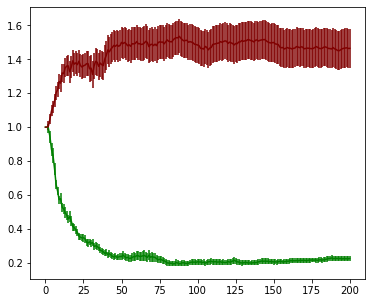

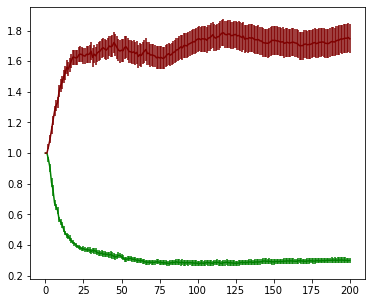

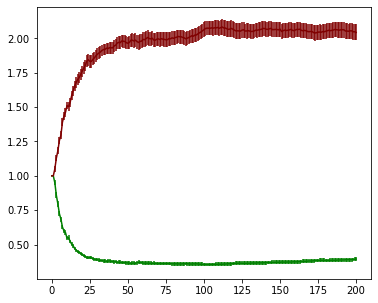

In [ ]:
# same thing but for noHebb - 
Hebb = False
states = learning.simulate(params,n_states,n_trials,env=env_start,hebb=hebb,crit=crit,v0=v0,r_mag=r_mag,l_mag=l_mag,norm=norm,mag=mag,anneal=anneal,pgrad=pgrad,T=T,mod=mod,phi=phi,k=k,decay_to_prior=decay_to_prior,decay_to_prior_gamma=decay_to_prior_gamma,env_switch=env_switch,switch=switch)

# plot
 
fig1, axs1 = plt.subplots(figsize=(6, 5))
fig2, axs2 = plt.subplots(figsize=(6, 5))
fig3, axs3 = plt.subplots(figsize=(6, 5))

axs=[axs1, axs1]
plot_dynamics.avg_qs(states,n_trials,n_states,0,axs,.5)
axs=[axs2, axs2]
plot_dynamics.avg_qs(states,n_trials,n_states,1,axs,.5)
axs=[axs3, axs3]
plot_dynamics.avg_qs(states,n_trials,n_states,2,axs,.5)